In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16804089334396377899
]


In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


In [3]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.regularizers import l2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tflearn
import numpy as np
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.normalization import local_response_normalization
from alexnet_additional_layers import split_tensor, cross_channel_normalization
from decode_predictions import decode_classnames_json, decode_classnumber
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

from Eve import Eve

%matplotlib inline

Using TensorFlow backend.
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


___

In [4]:
train_dir = 'data/Reinhard'

In [5]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/training 0
data/training/Invasive 7
data/training/Normal 7
data/training/InSitu 7
data/training/Benign 7


In [6]:
target_size = (256, 256)
img_rows, img_cols = (256, 256)
nb_classes = 4

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.25)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


#target_size: Tuple of integers (height, width), default: (256, 256). 
#The dimensions to which all images found will be resized.

#target_size = (height, width)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        batch_size=32,
        subset="training",
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        batch_size=32,
        subset = "validation",
        shuffle = True)

Found 24 images belonging to 4 classes.
Found 4 images belonging to 4 classes.


In [8]:
## Intilizing variables
output_classes = 4
batch_size = 32 
epochs = 30

sgd_opt = SGD(lr=1E-2, decay=1E-4, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1E-4)
eve_opt = Eve(lr=1E-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

In [9]:
def Lenet3():
    x_input = Input(shape=(img_rows, img_cols, 3), name="input")
    x = Conv2D(20, (5,5), padding="same")(x_input)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    #second set of CONV, RELU, POOl layers
    x = Conv2D(50, (5,5), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    #third set of CONV, RELU and POOL layers
    x = Conv2D(100, (5,5), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    #fourth set of CONV, RELU and POOL layers
    x = Conv2D(200, (5,5), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    # first set of FC layer => RELU
    x = Flatten()(x)
    x = Dense(500)(x)
    x = Activation("relu")(x)
    # second set of FC layer => RELU
    x = Dense(500)(x)
    x = Activation("relu")(x)
    #softmax classifier
    x = Dense(nb_classes)(x)
    x = Activation('softmax')(x)

    Lenet3 = Model(inputs=[x_input], outputs=[x])

    return Lenet3

In [10]:
model = Lenet3()
model.summary()
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam_opt,
              metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 20)      1520      
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 50)      25050     
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 50)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 50)        0         
__________

In [11]:
num_train_samples= len(train_generator.filenames)
num_train_samples

24

In [12]:
num_val_samples= len(validation_generator.filenames)
num_val_samples

4

In [13]:
history = model.fit_generator(train_generator,
        steps_per_epoch =int(np.ceil(num_train_samples * 1.0 / batch_size)),
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps=int(np.ceil(num_val_samples * 1.0 / batch_size)))

Epoch 1/30
1/1 [==============================] - 19s 19s/step - loss: 1.3856 - acc: 0.3750 - val_loss: 1.3817 - val_acc: 0.2500
Epoch 2/30
1/1 [==============================] - 12s 12s/step - loss: 1.3804 - acc: 0.2500 - val_loss: 1.3796 - val_acc: 0.2500
Epoch 3/30
1/1 [==============================] - 13s 13s/step - loss: 1.3749 - acc: 0.2500 - val_loss: 1.3631 - val_acc: 0.2500
Epoch 4/30
1/1 [==============================] - 13s 13s/step - loss: 1.3630 - acc: 0.5417 - val_loss: 1.3538 - val_acc: 0.5000
Epoch 5/30
1/1 [==============================] - 12s 12s/step - loss: 1.3468 - acc: 0.4167 - val_loss: 1.3314 - val_acc: 0.7500
Epoch 6/30
1/1 [==============================] - 10s 10s/step - loss: 1.3263 - acc: 0.7083 - val_loss: 1.3122 - val_acc: 0.7500
Epoch 7/30
1/1 [==============================] - 9s 9s/step - loss: 1.2993 - acc: 0.6250 - val_loss: 1.2925 - val_acc: 0.7500
Epoch 8/30
1/1 [==============================] - 8s 8s/step - loss: 1.2769 - acc: 0.5833 - val_los

In [14]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [15]:
history.history["val_loss"]

[1.3816745281219482,
 1.3795766830444336,
 1.3630549907684326,
 1.3538289070129395,
 1.3313698768615723,
 1.3122425079345703,
 1.2925286293029785,
 1.245747447013855,
 1.2565670013427734,
 1.1950979232788086,
 1.13594651222229,
 1.1418609619140625,
 1.1284401416778564,
 1.0651373863220215,
 1.0571069717407227,
 0.9212374687194824,
 0.9296648502349854,
 0.9901253581047058,
 0.8644790053367615,
 0.7943826913833618,
 0.7766256928443909,
 0.8732014894485474,
 0.7781915068626404,
 0.6316050291061401,
 0.7988675236701965,
 0.7982267141342163,
 0.6166728734970093,
 0.6085627675056458,
 0.9298376441001892,
 0.6464012861251831]

In [16]:
history.history["val_acc"]

[0.25,
 0.25,
 0.25,
 0.5,
 0.75,
 0.75,
 0.75,
 0.75,
 0.5,
 0.5,
 0.5,
 0.5,
 0.25,
 0.5,
 0.75,
 0.75,
 1.0,
 0.5,
 0.5,
 0.75,
 0.75,
 0.5,
 0.5,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75]

In [17]:
history.history["loss"]

[1.3856486082077026,
 1.3803739547729492,
 1.374902367591858,
 1.3629964590072632,
 1.346784234046936,
 1.3263099193572998,
 1.299298644065857,
 1.2769042253494263,
 1.2261255979537964,
 1.1835943460464478,
 1.1226773262023926,
 1.0889625549316406,
 1.067827582359314,
 1.0121244192123413,
 0.9775981307029724,
 0.9808184504508972,
 0.8998745083808899,
 0.9325076937675476,
 0.8834397792816162,
 0.8344898223876953,
 0.8276475071907043,
 0.7696582674980164,
 0.7907072901725769,
 0.7669456601142883,
 0.7135575413703918,
 0.7895600199699402,
 0.6709734797477722,
 0.771755039691925,
 0.6735320687294006,
 0.8122928738594055]

In [18]:
history.history["acc"]

[0.375,
 0.25,
 0.25,
 0.5416666865348816,
 0.4166666567325592,
 0.7083333134651184,
 0.625,
 0.5833333134651184,
 0.75,
 0.7083333134651184,
 0.5,
 0.5833333134651184,
 0.5833333134651184,
 0.5833333134651184,
 0.625,
 0.625,
 0.6666666865348816,
 0.75,
 0.5833333134651184,
 0.625,
 0.5,
 0.6666666865348816,
 0.6666666865348816,
 0.5833333134651184,
 0.6666666865348816,
 0.7083333134651184,
 0.7916666865348816,
 0.6666666865348816,
 0.75,
 0.5416666865348816]

In [19]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.6230254769325256
Test Accuracy:  0.75


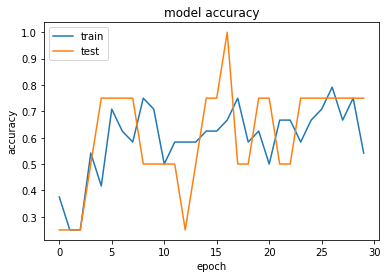

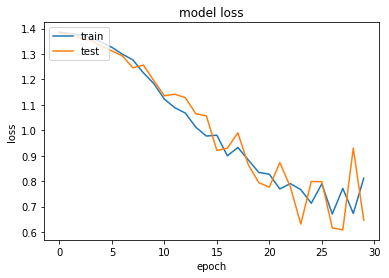

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

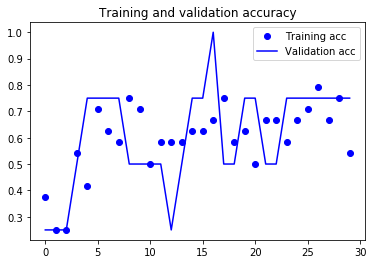

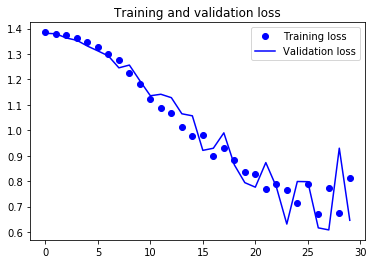

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


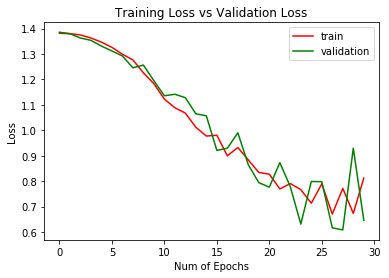

In [22]:
import numpy as np
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [23]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [24]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

1/0 [================================================================================================================================================================================================================================================] - 1s 758ms/step
No of errors = 4/4


Confusion Matrix
[[0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]]


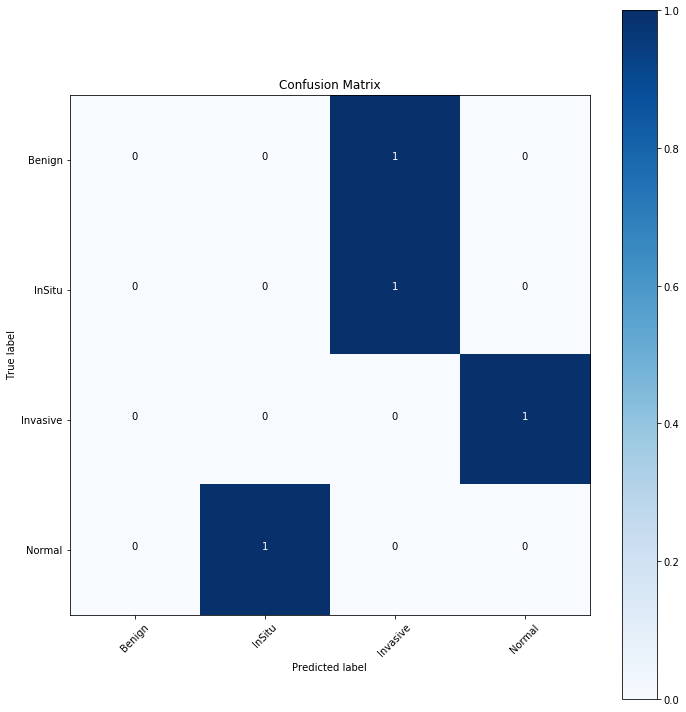

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [27]:
predict_and_report(train_generator, model)

Accuracy: 0.25
Area Under the Receiver Operating Characteristic Curve: 0.16666666666666669
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        18
          1       0.50      1.00      0.67         6
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0

avg / total       0.12      0.25      0.17        24



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
predict_and_report(validation_generator, model)

Accuracy: 0.25
Area Under the Receiver Operating Characteristic Curve: 0.0
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       1.00      1.00      1.00         1
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0

avg / total       0.25      0.25      0.25         4



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [29]:
best_train_acc = max(history.history['acc'])
best_train_acc

0.7916666865348816

In [30]:
last_train_acc = history.history['acc'][-1]
last_train_acc

0.5416666865348816

In [31]:
model.save('models/4.LeNet3-Adam-Model.h5')
model.save_weights('models/4.LeNet3-Adam-Weights.h5')